In [ ]:
'https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/silver_34715_20011-001_20016-002_0019d_s01_L090_01_int_grd.zip'

In [6]:
# import libraries
import re
import zipfile
import getpass
from osgeo import gdal 
import os  # for chdir, getcwd, path.basename, path.exists
import pandas as pd # for DatetimeIndex
import codecs # for text parsing code
import netrc
import rasterio as rio
import glob
import io

In [2]:
# Get NASA EARTHDATA Credentials from ~/.netrc or manual input
try:
    os.chmod('/home/jovyan/.netrc', 0o600) #only necessary on jupyterhub
    (ASF_USER, account, ASF_PASS) = netrc.netrc().authenticators("urs.earthdata.nasa.gov")
except:
    ASF_USER = input("Enter Username: ")
    ASF_PASS = getpass.getpass("Enter Password: ")

In [3]:
# directory in which the notebook resides
if 'tutorial_home_dir' not in globals():
     tutorial_home_dir = os.getcwd()
print("Notebook directory: ", tutorial_home_dir)

if not os.path.exists('/tmp/'):
    os.chdir('/tmp')
   
# directory for data downloads

data_dir = os.path.join('/tmp')
os.makedirs(data_dir, exist_ok=True)
print(data_dir)

Notebook directory:  /home/jovyan/uavsar
/tmp


In [1]:
#use for deleting contents of temp directory if needed. DO NOT uncomment, this will cause the notebook to fail.

files = glob.glob("/tmp/*.*")
for f in files:
   os.remove(f)

NameError: name 'glob' is not defined

In [4]:
%%time 

files = ['https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/silver_34715_20011-001_20016-002_0019d_s01_L090_01_int_grd.zip']
    
for file in files:
    print(f'downloading {file}...')
    filename = os.path.basename(file)
    
    if not os.path.exists(os.path.join(data_dir,filename)):
        cmd = "wget -q {0} --user={1} --password={2} -P {3} -nc".format(file, ASF_USER, ASF_PASS, data_dir)
        os.system(cmd) ##Should probably be a subprocess.call(cmd) - not quite sure why but that is the perfered method
    else:
        print(filename + " already exists. Skipping download ..")
        
print("done")

downloading https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/silver_34715_20011-001_20016-002_0019d_s01_L090_01_int_grd.zip...
done
CPU times: user 12.2 ms, sys: 14.3 ms, total: 26.4 ms
Wall time: 11min 51s


In [10]:
# check to see if downloaded
# the *.* syntax means print all files in the directory

print(glob.glob("/tmp/*.*"))

for file in glob.glob("/tmp/*.*"):
    if not file.split('.')[-1] == 'zip':
        os.remove(file)

['/tmp/silver_34715_20011-001_20016-002_0019d_s01_L090_01_int_grd.zip']


In [11]:
# unzip

for file in glob.glob("/tmp/*.zip"):
    with zipfile.ZipFile(file, "r") as zip_ref:
        zip_ref.printdir()
        print('Extracting all the files now...')
        zip_ref.extractall('/tmp')
        print("done")

File Name                                             Modified             Size
silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.cor.grd 2020-07-22 20:04:24    210092040
silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.hgt.grd 2020-07-22 20:09:40    210092040
silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.int.grd 2020-07-22 20:09:52    420184080
silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.unw.grd 2020-07-22 20:10:06    210092040
silver_34715_20011-001_20016-002_0019d_s01_L090HV_01.cor.grd 2020-07-22 20:10:14    210092040
silver_34715_20011-001_20016-002_0019d_s01_L090HV_01.hgt.grd 2020-07-22 20:10:22    210092040
silver_34715_20011-001_20016-002_0019d_s01_L090HV_01.int.grd 2020-07-22 20:10:32    420184080
silver_34715_20011-001_20016-002_0019d_s01_L090HV_01.unw.grd 2020-07-22 20:10:50    210092040
silver_34715_20011-001_20016-002_0019d_s01_L090VH_01.cor.grd 2020-07-22 20:10:56    210092040
silver_34715_20011-001_20016-002_0019d_s01_L090VH_01.hgt.grd 2020-07-22 20

In [12]:
# clean up unwanted data from what we just downloaded

directory = '/tmp'
os.chdir(directory)
HV_files = glob.glob('*HV_01*') #define all HV
VV_files = glob.glob('*VV_01*') #define all VV
VH_files = glob.glob('*VH_01*') #define all VH
zips = glob.glob('*.zip') # define the zip files

# loops to remove them

for f in HV_files:
    os.remove(f)
    
for f in VV_files:
    os.remove(f)
    
for f in VH_files:
    os.remove(f)
    
for f in zips:
    os.remove(f)

In [ ]:
# First, let's print the annotation file to get a look at it's content
# these file contain a lot of information and can be very intimidating and hard to understand, but being able to read them is vital to working this UAVSAR data
for ann_file in glob.glob("/tmp/*.ann"):
    f = open(ann_file, 'r')
    file_contents = f.read()
    print (file_contents)
    #!head -n 15 /tmp/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.ann

In [14]:
# folder is path to a folder with an .ann (or .txt) and .grd files (.amp1, .amp2, .cor, .unw, .int)

def uavsar_tiff_convert(folder):
    """
    Builds a header file for the input UAVSAR .grd file,
    allowing the data to be read as a raster dataset.
    :param folder:   the folder containing the UAVSAR .grd and .ann files
    """

    os.chdir(folder)
    int_file = glob.glob(os.path.join(folder, 'int.grd'))

    # Empty lists to put information that will be recalled later.
    Lines_list = []
    Samples_list = []
    Latitude_list = []
    Longitude_list = []
    Files_list = []

    # Step 1: Look through folder and determine how many different flights there are
    # by looking at the HDR files.
    for files in os.listdir(folder):
        if files [-4:] == ".grd":
            newfile = open(files[0:-4] + ".hdr", 'w')
            newfile.write("""ENVI
description = {DESCFIELD}
samples = NSAMP
lines = NLINE
bands = 1
header offset = 0
data type = DATTYPE
interleave = bsq
sensor type = UAVSAR L-Band
byte order = 0
map info = {Geographic Lat/Lon, 
            1.000, 
            1.000, 
            LON, 
            LAT,  
            0.0000555600000000, 
            0.0000555600000000, 
            WGS-84, units=Degrees}
wavelength units = Unknown
                """
                          )
            newfile.close()
            if files[0:18] not in Files_list:
                Files_list.append(files[0:18])

    #Variables used to recall indexed values.
    var1 = 0

    #Step 2: Look through the folder and locate the annotation file(s).
    # These can be in either .txt or .ann file types.
    for files in os.listdir(folder):
        if Files_list[var1] and files[-4:] == ".txt" or files[-4:] == ".ann":
            #Step 3: Once located, find the info we are interested in and append it to
            # the appropriate list. We limit the variables to <=1 so that they only
            # return two values (one for each polarization of
            searchfile = codecs.open(files, encoding = 'windows-1252', errors='ignore')
            for line in searchfile:
                if "Ground Range Data Latitude Lines" in line:
                    Lines = line[65:70]
                    print(f"Number of Lines: {Lines}")
                    if Lines not in Lines_list:
                        Lines_list.append(Lines)

                elif "Ground Range Data Longitude Samples" in line:
                    Samples = line[65:70]
                    print(f"Number of Samples: {Samples}")
                    if Samples not in Samples_list:
                        Samples_list.append(Samples)

                elif "Ground Range Data Starting Latitude" in line:
                    Latitude = line[65:85]
                    print(f"Top left lat: {Latitude}")
                    if Latitude not in Latitude_list:
                        Latitude_list.append(Latitude)

                elif "Ground Range Data Starting Longitude" in line:
                    Longitude = line[65:85]
                    print(f"Top left Lon: {Longitude}")
                    if Longitude not in Longitude_list:
                        Longitude_list.append(Longitude)
    
                        
                 
            #Reset the variables to zero for each different flight date.
            var1 = 0
            searchfile.close()


    # Step 3: Open .hdr file and replace data for all type 4 (real numbers) data
    # this all the .grd files expect for .int
    for files in os.listdir(folder):
        if files[-4:] == ".hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = DATTYPE" in line:
                        sources.write(re.sub(line[12:19], "4", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
    
    # Step 3: Open .hdr file and replace data for .int file date type 6 (complex)                 
    for files in os.listdir(folder):
        if files[-8:] == ".int.hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = 4" in line:
                        sources.write(re.sub(line[12:13], "6", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
                        
    
    # Step 4: Now we have an .hdr file, the data is geocoded and can be loaded into python with rasterio
    # once loaded in we use gdal.Translate to convert and save as a .tiff
    
    data_to_process = glob.glob(os.path.join(folder, '*.grd')) # list all .grd files
    for data_path in data_to_process: # loop to open and translate .grd to .tiff, and save .tiffs using gdal
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_Float32)
    
    # Step 5: Save the .int raster, needs separate save because of the complex format
    data_to_process = glob.glob(os.path.join(folder, '*.int.grd')) # list all .int.grd files (only 1)
    for data_path in data_to_process:
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_CFloat32)

    print(".tiffs have been created")
    return

In [15]:
data_folder = '/tmp' # define folder where the .grd and .ann files are
uavsar_tiff_convert(data_folder) # call the tiff convert function, and it will print the information it extracted from the .ann file

Number of Lines: 7662

Number of Samples: 6855

Top left lat: 43.374080760000005  
Top left Lon: -116.937243120000005
.tiffs have been created


In [6]:
os.chdir(data_folder)
grd = glob.glob('*.grd') #define .grd
hdr = glob.glob('*.hdr*') #define .hdr

# remove both
for f in grd:
    os.remove(f)
    
for f in hdr:
    os.remove(f)

NameError: name 'data_folder' is not defined

In [7]:
# check what's in the directory, only .tiffs and our annotation file!
os.chdir('/tmp/')
print(glob.glob("*.*"))

['silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.cor.grd.tiff', 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.hgt.grd.tiff', 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.unw.grd.tiff', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.int.grd.tiff', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff', 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.ann', 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.int.grd.tiff', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff', 'grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff', 'gmesa_depth_change_02-01_02-13.tif']


In [8]:
### inspect our newly created .tiffs, and create named objects for each data type. We'll use these new obects in the next step

# amplitude from the first acquisition
for amp1 in glob.glob("*amp1.grd.tiff"):
    print(amp1)
    
# amplitude from the second acquisition
for amp2 in glob.glob("*amp2.grd.tiff"):
    print(amp2)

# coherence
for cor in glob.glob("*cor.grd.tiff"):
    print(cor)

# unwrapped phase
for unw in glob.glob("*unw.grd.tiff"):
    print(unw)

# dem used in processing
for dem in glob.glob("*hgt.grd.tiff"):
    print(dem)

grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff
silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.cor.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff
silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.unw.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff
silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.hgt.grd.tiff
grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff


In [9]:
unw_rast = rio.open(unw)
meta_data = unw_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 7014, 'height': 4768, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -108.30355248000001,
       0.0, -5.556e-05, 39.19030164), 'tiled': False, 'interleave': 'band'}


8.186853


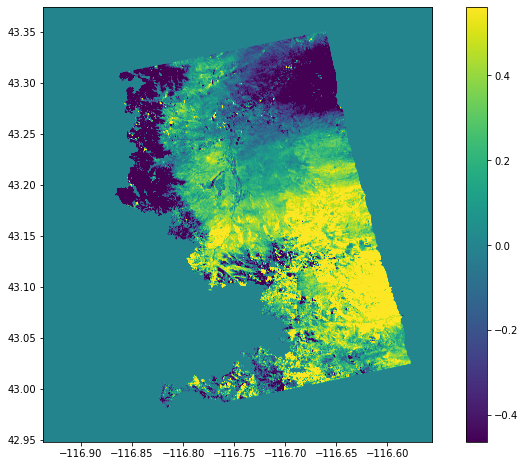

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
import rasterio as rio
src = rio.open('silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.unw.grd.tiff')
print(src.read(1).max())
fig, ax = plt.subplots(figsize=(12, 8))

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(src.read(1), 
                         cmap='viridis', 
                         vmin=np.percentile(src.read(1), 5), 
                         vmax=np.percentile(src.read(1), 95))

# plot on the same axis with rio.plot.show
image = show(src.read(1), 
                      transform=src.transform, 
                      ax=ax, 
                      cmap='viridis', 
                      vmin=np.percentile(src.read(1), 5), 
                      vmax=np.percentile(src.read(1), 95))

# add colorbar using the now hidden image
fig.colorbar(image_hidden, ax=ax)

In [11]:
src = rio.open('silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.int.grd.tiff')
a = (src.read(1))
b = np.arctan(np.divide(a.imag, a.real, out=np.zeros_like(a), where=a.real!=0))

<ipython-input-11-315211c024d0>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.arctan(np.divide(a.imag, a.real, out=np.zeros_like(a), where=a.real!=0))


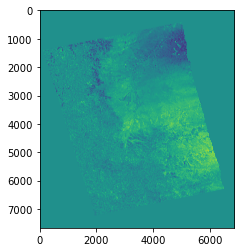

0.04755627


In [19]:
from rasterio.plot import show
show(b.real)
c = b.real
print(c.mean())

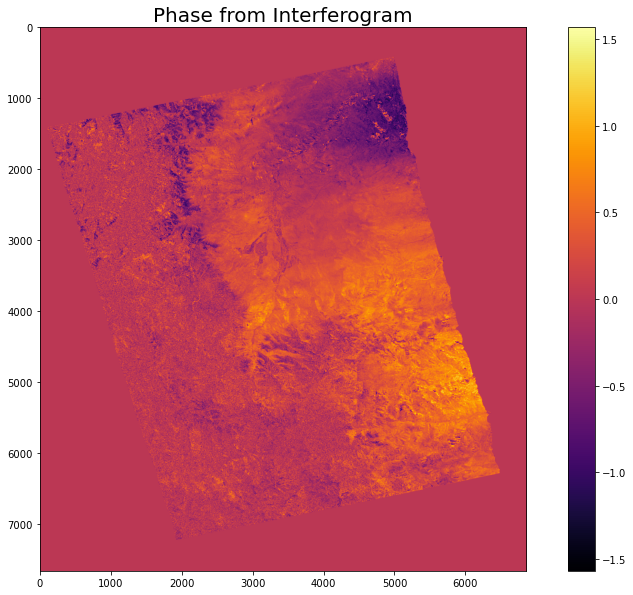

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Phase from Interferogram", fontsize= 20) #title and font size
amp2_plot = ax.imshow(c, cmap='inferno',vmin=c.min(), vmax=c.max()) #set bounds and color map

# add legend
colorbar = fig.colorbar(amp2_plot, ax=ax) #add color bar
plt.show()

In [2]:
import wget